# 6.6 Future Toronto Electricity Demands from Cooling

This is a worked example of the UTCDW workflow examining the impact of future extreme heat on energy demand in Toronto, Ontario. While less pedagogically focused than the previous worked examples, it shows how a user of the might implement the workflow in practice. This example was developed by Cassandra Chanen and edited by Michael Morris.

According to IESO, air-conditioning accounts for roughly one-third of Ontario's electricity use on hot summer days. In 2019, Environment and Climate Change Canada released a report that found Canada is warming at rougly twice the global average rate [1]. Toronto is particularly important to study because it is an urban heat island, and because Toronto and its surrounding areas are heavily populated.
While understanding future energy demand is a complex question that could influenced by a wide range of variables, it is key that understanding future heat is a crucial component.

[1] (Bush, E. and Lemmen, D.S., editors (2019): Canada’s Changing Climate Report; Government of Canada, Ottawa, ON. 444 p.)

## 6.6.1 Survey Output

In order to explore this question, we first filled out the UTCDW survey. This survey guides the user through key questions that need to be answered in order to proceed with the downscaling process.

Two historical time periods (1981-2000 and 2001-2020) and two future time periods (2031-2050 and 2081-2100) were selected. CanESM5 was chosen for the model data, and a combination of station data and NRCan gridded data was chosen for the observation data. 

Cooling degree days was chosen as an engineering indicator because it is a commonly used to project energy consumption from cooling. Cooling degree days are calculated using the number of degrees above 18 degrees Celcius the average temperature is on a given day. For example, if the average temperature is 20 degrees on a given day that day has a CDD value of 2. If it is 20 degrees for an entire week, there are 14 CDDs that week.

Daily temperatures were chosen as the relevant climactic indicators required to calculate cooling degree days.

<img src="Toronto_Electricity_Images/survey.png" alt="Survey">

## 6.6.2 Point-Based Downscaling: Quantile-Delta Mapping

### 6.6.2.1 Downloading Data

**Model Data**

The following code was used to download CanESM5 data for ssp245 and ssp434.

**NRCan Gridded Observations**

The following python code was used to download NRCan data for Southern Ontario from 1981-2020:

**Station Data**

The following python code was used to download station data for Southern Ontario from 1981-2020:

### 6.6.2.2 Plotting Station Data

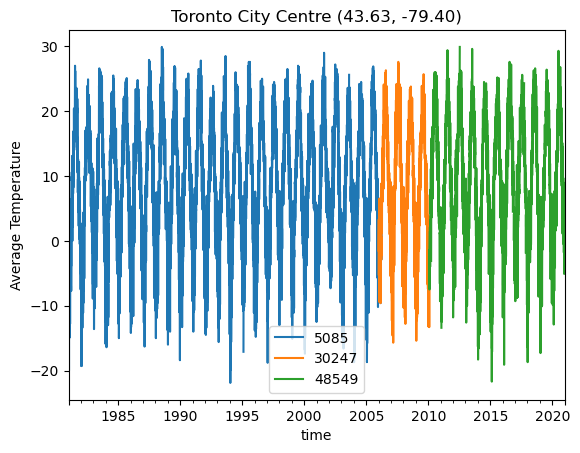

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import nc_time_axis

spkws = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree())

%matplotlib inline

from siphon.catalog import TDSCatalog
from xclim.core.calendar import convert_calendar, percentile_doy
import xclim.indices as xci

ct = 0
avg_lat = [0,0,0]
avg_lon = [0,0,0]
for i in [5085, 30247, 48549]: 
    df = pd.read_csv('/home/cchanen/UTCDW/data/station/'+str(i)+'-daily-1981-2020.csv')
    #print(df.head())

    column_name_dict = {'Date/Time': 'time', 
                        'Max Temp (°C)': 'MaxTemp', 
                        'Min Temp (°C)': 'MinTemp',
                        'Mean Temp (°C)': 'tas',
                        'Total Precip (mm)': 'TotalPrecip',
                        'Latitude (y)': 'lat',
                        'Longitude (x)': 'lon',
                        'Station Name': 'Name'}

    df = df.rename(columns = column_name_dict)
    df = df[list(column_name_dict.values())]
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index("time")
    df = df.sort_index()
    
    avg_lat[ct] = np.average(df["lat"])
    avg_lon[ct] = np.average(df["lon"])

    df["tas"].plot(label = i)
    ct = ct + 1
    if ct == 1:
        df1 = df.dropna(inplace = False)
    if ct == 2:
        df2 = df.dropna(inplace = False)
    if ct == 3:
        df3 = df.dropna(inplace = False)
plt.legend()
plt.title('Toronto City Centre (%2.2f, %2.2f)' %(np.average(avg_lat), np.average(avg_lon)))
plt.ylabel('Average Temperature')
plt.show()

In [2]:
# merge the data from different station IDs into a single dataframe
df_tor_int = pd.concat([df1[df1.index < df2.index.min()], df2], ignore_index=False)
stn_df = pd.concat([df_tor_int , df3], ignore_index=False)

# now convert it to xarray format for easier use with the model data and xclim
# drop lat and lon variables, since we want these to be coordinates in the xr.Dataset
stn_lon = stn_df.lon.values[0] + 360 # convert lon to same convention as model data
stn_lat = stn_df.lat.values[0] 
stn_df = stn_df.drop(['lat', 'lon'], axis = 1)

stn_ds = xr.Dataset.from_dataframe(stn_df)
stn_ds = stn_ds.assign_coords(lat = stn_lat, lon = stn_lon)
stn_ds
stn_ds_1981_2000 = stn_ds.sel(time=slice('1981-01-01', '2000-12-31'))
stn_ds_2001_2020 = stn_ds.sel(time=slice('2001-01-01', '2020-12-31'))

### 6.6.2.3 Plotting Model Data

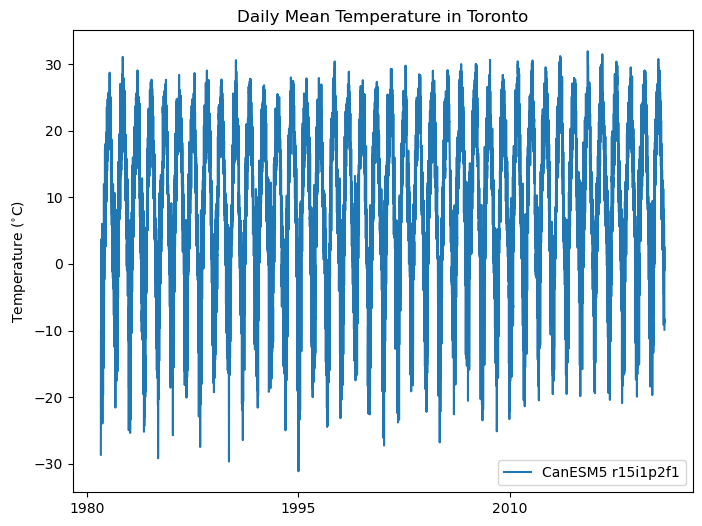

In [3]:
# first open the CanESM5 data, all files at once - open_mfdataset will automatically concatenate them in time
data_directory = '/data/kushner_group/CMIP6/CanESM5/historical/atmos/tas/day'
ds_CanESM5 = xr.open_mfdataset([data_directory + "/tas_day_CanESM5_historical_r15i1p2f1_gn_18500101-20141231.nc", data_directory + "/tas_day_CanESM5_ssp585_r15i1p2f1_gn_20150101-21001231.nc"])
tas_CanESM5_full = ds_CanESM5.tas.interp(lat = np.average(avg_lat), lon = (np.average(avg_lon) + 360)) - 273.15
tas_CanESM5 = tas_CanESM5_full.sel(time=slice('1981-01-01', '2020-12-31'))
tas_CanESM5_1981_2000 = tas_CanESM5_full.sel(time=slice('1981-01-01', '2000-12-31'))
tas_CanESM5_2001_2020 = tas_CanESM5_full.sel(time=slice('2001-01-01', '2020-12-31'))

tas_CanESM5_2031_2050 = tas_CanESM5_full.sel(time=slice('2031-01-01', '2050-12-31'))
tas_CanESM5_2081_2100 = tas_CanESM5_full.sel(time=slice('2081-01-01', '2100-12-31'))

fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(tas_CanESM5_full.time.values[47815:62414], tas_CanESM5_full[47815:62414], label = 'CanESM5 r15i1p2f1')
ax.set_title("Daily Mean Temperature in Toronto")
ax.set_ylabel(r"Temperature ($^{\circ}$C)")
plt.legend()
plt.show()

### 6.6.2.4 Calculating Climatologies and Plotting Temperature Distribution

In [4]:
# calculate station daily climatology again after converting its calendar to match the model
stn_ds_noleap = convert_calendar(stn_ds, 'noleap')
tas_obs_noleap = stn_ds_noleap.tas

tas_dailyclim_obs = tas_obs_noleap.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_obs = tas_obs_noleap.groupby('time.dayofyear').std('time').compute()

tas_dailyclim_CanESM5 = tas_CanESM5.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_CanESM5 = tas_CanESM5.groupby('time.dayofyear').std('time').compute()

In [5]:
# fit Kernel Density Estimator so we can plot a smooth distribution
kde_hist_raw = stats.gaussian_kde(tas_CanESM5.values)
kde_obs = stats.gaussian_kde(tas_obs_noleap.values) 

# means and stdev ratios
tas_hist_raw_mean = tas_CanESM5.mean('time').compute()
tas_obs_mean = tas_obs_noleap.mean('time').compute()

# stdevs for each dataset
tas_hist_raw_stdev = tas_CanESM5.std('time').compute()
tas_obs_stdev = tas_obs_noleap.std('time').compute()

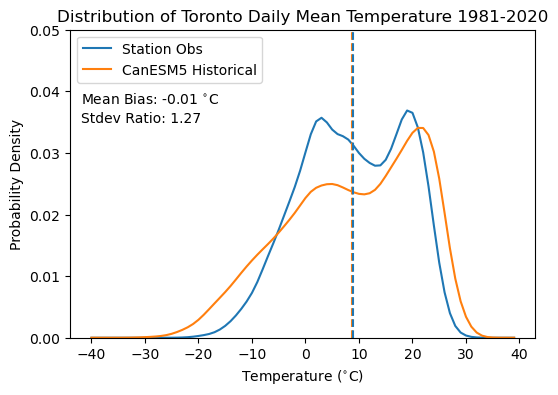

In [6]:
# plot the PDFs smoothed by KDE
temperatures = np.arange(-40, 40)
plt.figure(figsize = (6,4))
plt.title("Distribution of Toronto Daily Mean Temperature 1981-2020")
plt.plot(temperatures, kde_obs(temperatures), label = 'Station Obs', color = 'tab:blue')
plt.plot(temperatures, kde_hist_raw(temperatures), label = 'CanESM5 Historical', color = 'tab:orange')
plt.vlines([tas_hist_raw_mean, tas_obs_mean], 0, 1, colors = ['tab:orange', 'tab:blue'], linestyles = '--')
plt.ylim(0, 0.05)
plt.xlabel(r"Temperature ($^{\circ}$C)")
plt.ylabel("Probability Density")
plt.legend(loc = 'upper left')

# annotate with mean bias and ratio of stdevs
plt.text(-42, 0.038, r'Mean Bias: %.2f $^{\circ}$C' % (tas_hist_raw_mean - tas_obs_mean))
plt.text(-42, 0.035, r'Stdev Ratio: %.2f' % (tas_hist_raw_stdev / tas_obs_stdev))

plt.show()

### 6.6.2.5 Plotting Cooling Degree Days

In [7]:
# add unit attributes to tas data for use with xclim routines
tas_obs_noleap.attrs['units'] = 'degC'
tas_CanESM5.attrs['units'] = 'degC'

# calculate CDDs
cdd_obs = xci.cooling_degree_days(tas_obs_noleap).compute()
cdd_hist_raw = xci.cooling_degree_days(tas_CanESM5).compute()

# long-term means for the historical period
cdd_obs_ltm = cdd_obs.mean('time').compute()
cdd_hist_raw_ltm = cdd_hist_raw.mean('time').compute()

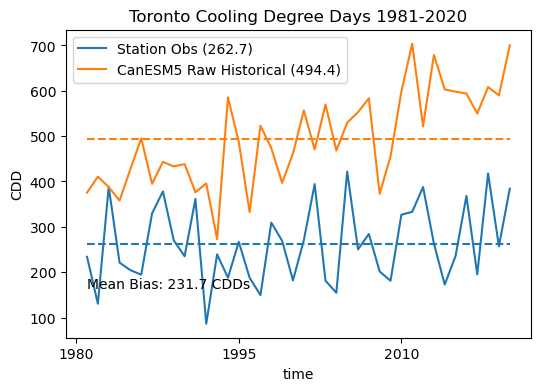

In [8]:
# plot timeseries of CDDs for model historical and obs
fig, ax = plt.subplots(figsize = (6, 4))
cdd_obs.plot.line(label = "Station Obs (%.1f)" % cdd_obs_ltm.values, color = 'tab:blue')
cdd_hist_raw.plot.line(label = "CanESM5 Raw Historical (%.1f)" % cdd_hist_raw_ltm.values, color = 'tab:orange')

# plot long-term means
ax.hlines([cdd_obs_ltm.values, cdd_hist_raw_ltm.values], 
          cdd_obs.time.min().values, cdd_obs.time.max().values, 
          colors = ['tab:blue', 'tab:orange'], linestyles = '--')

ax.set(title = "Toronto Cooling Degree Days 1981-2020", ylabel = "CDD")
ax.legend()

# show the mean bias on the plot
ax.text(cdd_obs.time[0].values, 165, "Mean Bias: %.1f CDDs" % (cdd_hist_raw_ltm.values - cdd_obs_ltm.values))
plt.show()

The results of this plot demonstrate that even a relatively small mean temperature bias (-0.01) can translate to a significant mean CDD bias (231.7).

## 6.6.3 Downscaling with a Spatial Dimension: DBCCA

This section adds a spatial dimension to the downscaling problem approached in the previous section (Cooling Degree Days in Southern Ontario). The downscaling technique used is Double Bias Correction Constructed Analogs (DBCCA).

DBCCA code can be downloaded from the UTCDW Github.

In [10]:
# add the downscaling_code directory to the PATH so the functions can be imported. 
# you will need to change the argument passed to sys.path.append() to be wherever you
# saved the scripts when you cloned the repository or downloaded the scripts individually.
import sys
sys.path.append("/home/mmorris/UTCDW_Guidebook/downscaling_code")

# now import the DBCCA function
from DBCCA import DBCCA

# import other the necessary packages
import numpy as np
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import pandas as pd
import ec3
import xclim.indices as xci
from xclim.core.calendar import convert_calendar
import gcsfs
import zarr
import os

spkws = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree())

# spatial boundaries of our study region - a 5x5 degree region around Toronto
lat_bnds = [43.63-2.5, 43.63+2.5]
lon_bnds = [-79.4-2.5, -79.4+2.5]
lon_bnds360 = [l + 360 for l in lon_bnds]

# lat and lon coordinates for Toronto
lat_tor = 43.63
lon_tor = -79.4

# time periods for historical and future periods
years_hist = range(1981, 2000)
years_future = range(2071, 2100)

# url for the CSV file that contains the CMIP model data catalog
url_gcsfs_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

# PAVICS URL for ERA5 data
url_pavics_era5 = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/reanalyses/catalog.xml"

# access the ERA5-LAND data through the OPenDAP server
cat = TDSCatalog(url_pavics_era5)
ix = list(cat.datasets).index("day_ERA5-Land_NAM.ncml")
era5_ds = xr.open_dataset(cat.datasets[ix].access_urls["OPENDAP"])

# subset spatially and temporally
tas_obs = era5_ds.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds), 
                          time = era5_ds.time.dt.year.isin(years_hist))
# convert units
tas_obs = tas_obs - 273.15

# convert calendar to noleap
tas_obs = convert_calendar(tas_obs, 'noleap')

# first open the NRCan data, all files at once - open_mfdataset will automatically concatenate them in time
data_directory = '/home/cchanen/UTCDW/nrcan_data'
nrcan_1981_tmin = xr.open_mfdataset([data_directory + "/tasmin_NRCAN_sontario.1981-2000.nc"])
nrcan_1981_tmax = xr.open_mfdataset([data_directory + "/tasmax_NRCAN_sontario.1981-2000.nc"])

nrcan_tas = nrcan_1981_tmin.assign(tavg=0.5*nrcan_1981_tmin["tasmin"] + 0.5*nrcan_1981_tmax["tasmax"])
nrcan_tas_2 = nrcan_tas['tavg']
nrcan_min_dailyclim_1981 = nrcan_1981_tmin.groupby('time.month').mean('time').compute()
nrcan_max_dailyclim_1981 = nrcan_1981_tmax.groupby('time.month').mean('time').compute()
nrcan_dailyclim_1981 = nrcan_min_dailyclim_1981
print(nrcan_dailyclim_1981)
nrcan_dailyclim_1981_2 = nrcan_dailyclim_1981.assign(tavg=(0.5*nrcan_min_dailyclim_1981["tasmin"] + 0.5*nrcan_max_dailyclim_1981["tasmax"]) - 273.15)
nrcan_dailyclim_1981_2.drop_vars('tasmin')

nrcan_tas_obs = nrcan_dailyclim_1981_2.tavg

# download the CESM2 model data from Google Cloud - this code is mostly the same as 6.1

# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for our selected model, both historical and SSP3-7.0 scenarios
search_string = "table_id == 'day' & source_id == 'CESM2' & variable_id == 'tas'" # continue on the next line
search_string += " & experiment_id == ['historical', 'ssp370']"
df_search = df_catalog.query(search_string)

# filter the search results further for the ensemble member we want to use
df_search_r10i1p1f1 = df_search.query("member_id == 'r10i1p1f1'")

# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# get the URLs for each dataset and turn into zarr store mappers
url_hist = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'historical'].zstore.values[0]
mapper_hist = gcs.get_mapper(url_hist)
url_ssp3 = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'ssp370'].zstore.values[0]
mapper_ssp3 = gcs.get_mapper(url_ssp3)

# download the datasets, subset, and convert units
# historical
ds_hist_raw = xr.open_zarr(mapper_hist, consolidated = True)
tas_hist_raw = ds_hist_raw.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds360)) - 273.15 # also convert to C

# future
ds_ssp3_raw = xr.open_zarr(mapper_ssp3, consolidated = True)
tas_ssp3_raw = ds_ssp3_raw.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds360)) - 273.15 


<xarray.Dataset>
Dimensions:  (lat: 108, lon: 48, month: 12)
Coordinates:
  * lat      (lat) float32 49.96 49.88 49.79 49.71 ... 41.29 41.21 41.12 41.04
  * lon      (lon) float32 -81.96 -81.88 -81.79 -81.71 ... -78.21 -78.12 -78.04
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tasmin   (month, lat, lon) float32 247.9 247.8 247.7 247.6 ... nan nan nan


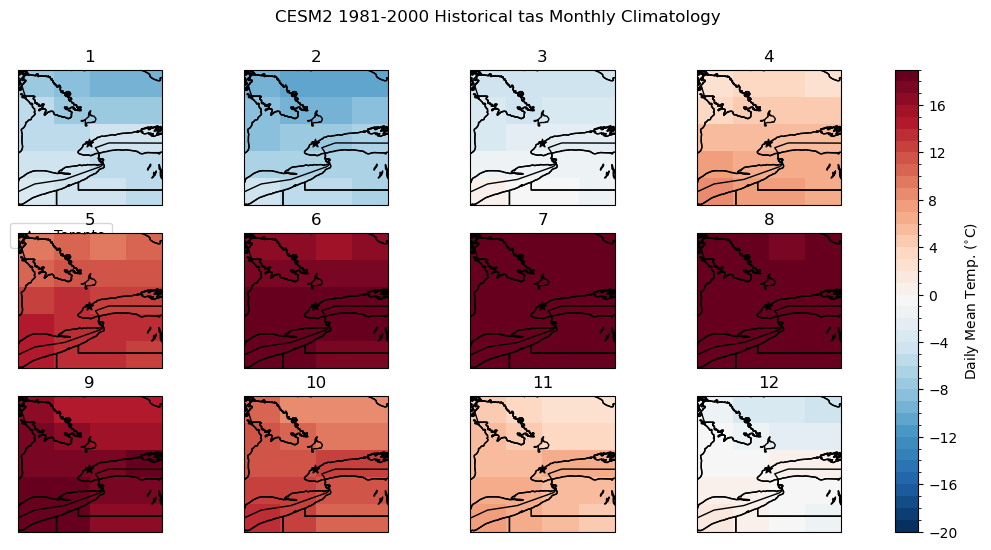

In [11]:
# select time periods
tas_hist_raw = tas_hist_raw.sel(time = tas_hist_raw.time.dt.year.isin(years_hist))
tas_ssp3_raw = tas_ssp3_raw.sel(time = tas_ssp3_raw.time.dt.year.isin(years_future))

# calculate the raw model historical monthly climatology
tas_hist_raw_monthlyclim = tas_hist_raw.groupby('time.month').mean('time').compute()

# same for observations
tas_obs_monthlyclim = tas_obs.groupby('time.month').mean('time').compute()

# plot model monthly clim
fig, axes_array = plt.subplots(nrows = 3, ncols = 4, subplot_kw = spkws, figsize = (14, 6))
axes = axes_array.ravel()
fig.suptitle("CESM2 1981-2000 Historical tas Monthly Climatology")
for i in range(len(axes)):
    p = tas_hist_raw_monthlyclim.sel(month = i+1).plot.pcolormesh(ax = axes[i],
                                                                  levels = np.arange(-20, 20, 1),
                                                                  cmap = 'RdBu_r',
                                                                  add_colorbar = False)
    axes[i].set_title(i + 1)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    axes[i].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    # label where Toronto is on the map
    axes[i].scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")

# add legend only to one panel
axes[0].legend(bbox_to_anchor = (0.7, -0.075)) 
fig.colorbar(p, ax = axes.tolist(), label = r"Daily Mean Temp. ($^{\circ}$C)")
plt.show()

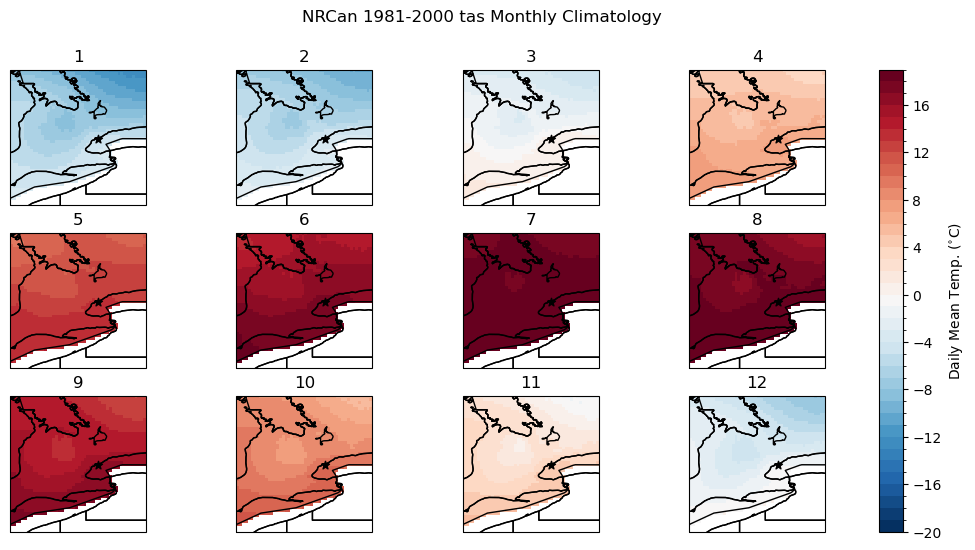

In [12]:
max_lat = 43.63-2
min_lat = 43.63+2

nrcan_tas_obs_cropped = nrcan_tas_obs.sel(lat=slice(min_lat,max_lat))

# plot obs monthly clim
fig, axes_array = plt.subplots(nrows = 3, ncols = 4, subplot_kw = spkws, figsize = (14, 6))
axes = axes_array.ravel()
fig.suptitle("NRCan 1981-2000 tas Monthly Climatology")
for i in range(len(axes)):
    p = nrcan_tas_obs_cropped.sel(month = i+1).plot.pcolormesh(ax = axes[i],
                                                                  levels = np.arange(-20, 20, 1),
                                                                  cmap = 'RdBu_r',
                                                                  add_colorbar = False)
    axes[i].set_title(i + 1)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    axes[i].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    axes[i].scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")
    
fig.colorbar(p, ax = axes.tolist(), label = r"Daily Mean Temp. ($^{\circ}$C)")
plt.show()

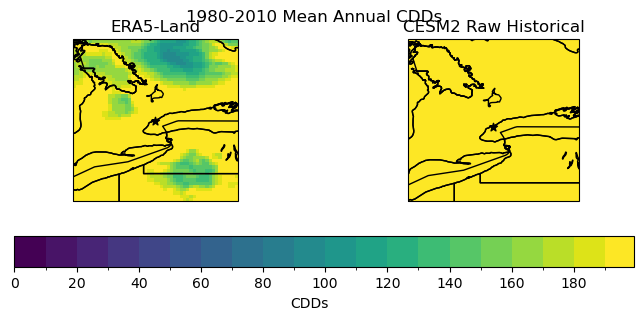

In [13]:
# add unit attribute required by xclim
tas_obs.attrs['units'] = 'degC'
tas_hist_raw.attrs['units'] = 'degC'
tas_ssp3_raw.attrs['units'] = 'degC'

# calculate CDDs for each dataset
cdds_obs = xci.cooling_degree_days(tas_obs).compute()
cdds_hist_raw = xci.cooling_degree_days(tas_hist_raw).compute()
cdds_ssp3_raw = xci.cooling_degree_days(tas_ssp3_raw).compute()

# long-term annual means
cdds_obs_ltm = cdds_obs.mean('time').compute()
cdd_hist_raw_ltm = cdds_hist_raw.mean('time').compute()
cdd_ssp3_raw_ltm = cdds_ssp3_raw.mean('time').compute()

# plot maps of long-term mean CDDs for raw historical and obs
levels_cdd = np.arange(0, 200, 10)
fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8, 3))
fig.suptitle("1980-2010 Mean Annual CDDs")
p0 = cdds_obs_ltm.plot.pcolormesh(ax = axes[0], add_colorbar = False, levels = levels_cdd)
axes[0].set_title("ERA5-Land")
p1 = cdd_hist_raw_ltm.plot.pcolormesh(ax = axes[1], add_colorbar = False, levels = levels_cdd)
axes[1].set_title("CESM2 Raw Historical")

fig.colorbar(p0, ax = axes.ravel().tolist(), label = "CDDs", orientation = 'horizontal', extendrect = True)

for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    ax.scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")

plt.show()

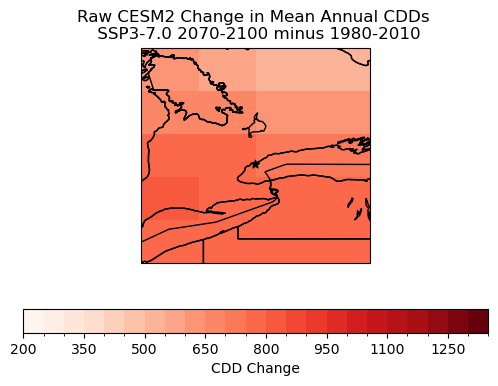

In [14]:
# plot maps of changes long-term mean CDDs for raw CanESM5
levels_cdd_delta = np.arange(200, 1400, 50)
fig, ax = plt.subplots( subplot_kw = spkws, figsize = (6, 4))

cdd_delta_raw = cdd_ssp3_raw_ltm - cdd_hist_raw_ltm

cdd_delta_raw.plot.pcolormesh(ax = ax, levels = levels_cdd_delta, 
                              cbar_kwargs = dict(orientation = 'horizontal', label = 'CDD Change'),
                              cmap = 'Reds')

ax.coastlines()
ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
ax.scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")

ax.set_title("Raw CESM2 Change in Mean Annual CDDs \n SSP3-7.0 2070-2100 minus 1980-2010")
plt.show()

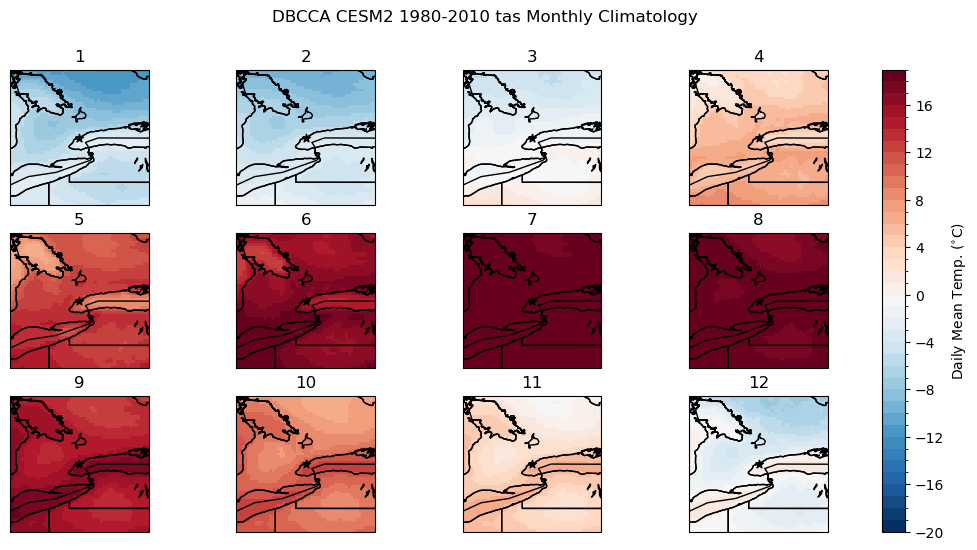

In [15]:
# de-chunk along the time dimension, required by xclim bias correction routines
tas_hist_raw = tas_hist_raw.chunk({'time': -1})
tas_ssp3_raw = tas_ssp3_raw.chunk({'time': -1})
tas_obs = tas_obs.chunk({'time': -1})

# file names for intermediate BCCA files - saving these will help the code run faster later on if all
# you want to do is the last QDM step

file_hist_bcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.CESM2.toronto.historical.r10i1p1f1.1980-2010.BCCA.nc"
file_ssp3_bcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.CESM2.toronto.ssp370.r10i1p1f1.2070-2100.BCCA.nc"

# file paths for DBCCA output - it's good to save this because the code can take a long time to run
file_hist_dbcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.CESM2.toronto.historical.r10i1p1f1.1980-2010.DBCCA.nc"
file_ssp3_dbcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.CESM2.toronto.ssp370.r10i1p1f1.2070-2100.DBCCA.nc"

# open pre-computed DBCCA data if it exists
if os.path.exists(file_hist_dbcca) and os.path.exists(file_ssp3_dbcca):
    ds_hist_dbcca = xr.open_dataset(file_hist_dbcca)
    tas_hist_dbcca = ds_hist_dbcca.tas
    ds_ssp3_dbcca = xr.open_dataset(file_ssp3_dbcca)
    tas_ssp3_dbcca = ds_ssp3_dbcca.tas 
else: # do the downscaling - this will only run if the input files don't already exist
    tas_hist_dbcca, tas_ssp3_dbcca = DBCCA(tas_hist_raw,
                                           tas_ssp3_raw,
                                           tas_obs,
                                           "tas", 
                                           units = "degC",
                                           fout_hist_bcca = file_hist_bcca,
                                           fout_future_bcca = file_ssp3_bcca,
                                           fout_hist_dbcca = file_hist_dbcca,
                                           fout_future_dbcca = file_ssp3_dbcca,
                                           write_output = True)
    
# calculate the downscaled model historical monthly climatology
tas_hist_dbcca_monthlyclim = tas_hist_dbcca.groupby('time.month').mean('time').compute()

# difference between downscaled and ERA5-Land
bias_clim_dbcca = tas_hist_dbcca_monthlyclim - tas_obs_monthlyclim

# plot model monthly clim
fig, axes_array = plt.subplots(nrows = 3, ncols = 4, subplot_kw = spkws, figsize = (14, 6))
axes = axes_array.ravel()
fig.suptitle("DBCCA CESM2 1980-2010 tas Monthly Climatology")
for i in range(len(axes)):
    p = tas_hist_dbcca_monthlyclim.sel(month = i+1).plot.pcolormesh(ax = axes[i],
                                                                    levels = np.arange(-20, 20, 1),
                                                                    cmap = 'RdBu_r',
                                                                    add_colorbar = False)
    axes[i].set_title(i + 1)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    axes[i].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    axes[i].scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")
    
fig.colorbar(p, ax = axes.tolist(), label = r"Daily Mean Temp. ($^{\circ}$C)")
plt.show()

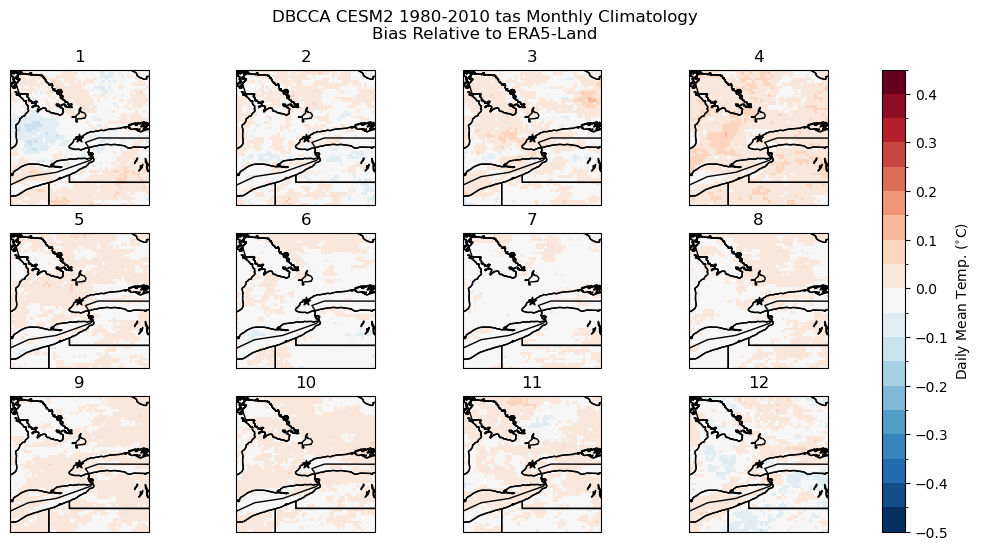

In [16]:
# plot model monthly clim bias
fig, axes_array = plt.subplots(nrows = 3, ncols = 4, subplot_kw = spkws, figsize = (14, 6))
axes = axes_array.ravel()
fig.suptitle("DBCCA CESM2 1980-2010 tas Monthly Climatology\nBias Relative to ERA5-Land")
for i in range(len(axes)):
    p = bias_clim_dbcca.sel(month = i+1).plot.pcolormesh(ax = axes[i],
                                                                    levels = np.arange(-0.5, 0.5, 0.05),
                                                                    cmap = 'RdBu_r',
                                                                    add_colorbar = False)
    axes[i].set_title(i + 1)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    axes[i].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    axes[i].scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")
    
fig.colorbar(p, ax = axes.tolist(), label = r"Daily Mean Temp. ($^{\circ}$C)")
plt.show()

In [17]:
# add units to downscaled data
tas_hist_dbcca.attrs['units'] = 'degC'

# calculate CDDs using the historical DBCCA data
cdds_hist_dbcca = xci.cooling_degree_days(tas_hist_dbcca).compute()

# long-term mean
cdds_hist_dbcca_ltm = cdds_hist_dbcca.mean('time')

# bias of the downscaled data
cdds_hist_dbcca_ltm_bias = cdds_hist_dbcca_ltm - cdds_obs_ltm

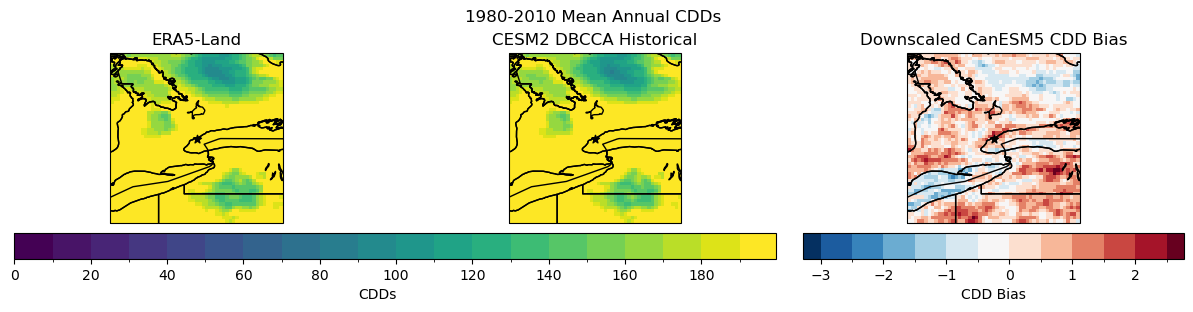

In [18]:
# compare DBCCA historical CDDs to ERA5-Land CDDs
levels_cdd = np.arange(0, 200, 10)
fig, axes = plt.subplots(ncols = 3, subplot_kw = spkws, figsize = (12, 3), constrained_layout=True)
fig.suptitle("1980-2010 Mean Annual CDDs")

# obs
p0 = cdds_obs_ltm.plot.pcolormesh(ax = axes[0], add_colorbar = False, levels = levels_cdd)
axes[0].set_title("ERA5-Land")

# downscaled model
p1 = cdds_hist_dbcca_ltm.plot.pcolormesh(ax = axes[1], add_colorbar = False, levels = levels_cdd)
axes[1].set_title("CESM2 DBCCA Historical")

fig.colorbar(p0, ax = axes[:2].ravel().tolist(), label = "CDDs", 
             orientation = 'horizontal', extendrect = True,
             aspect = 30)

# bias
levels_cdd_bias = np.arange(-3, 3, 0.5)
p2 = cdds_hist_dbcca_ltm_bias.plot.pcolormesh(ax = axes[2], add_colorbar = False, 
                                              levels = levels_cdd_bias, extend = 'both')
fig.colorbar(p2, ax = axes[2], label = "CDD Bias", 
             orientation = 'horizontal', extendrect = True,
             aspect = 15)
axes[2].set_title("Downscaled CanESM5 CDD Bias")

for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    ax.scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")

plt.show()

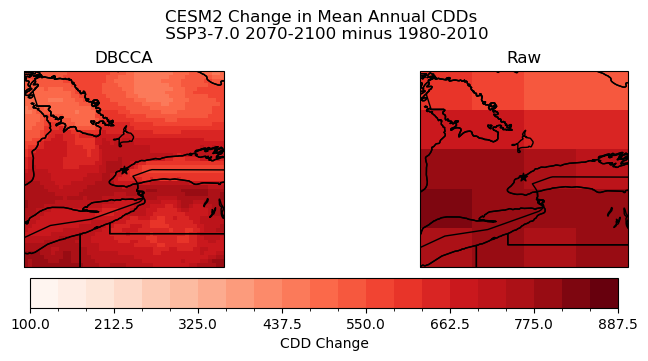

In [19]:
# add units to downscaled future data
tas_ssp3_dbcca.attrs['units'] = 'degC'

# calculate CDDs using the SSP3-7.0 DBCCA data
cdds_ssp3_dbcca = xci.cooling_degree_days(tas_ssp3_dbcca).compute()

# long-term mean
cdds_ssp3_dbcca_ltm = cdds_ssp3_dbcca.mean('time')

# climate change delta
cdds_delta_dbcca = cdds_ssp3_dbcca_ltm - cdds_hist_dbcca_ltm

# plot maps of changes long-term mean CDDs for raw and downscaled CESM2
levels_cdd_delta = np.arange(100, 900, 37.5)

fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8, 3.5), constrained_layout=True)

fig.suptitle("CESM2 Change in Mean Annual CDDs \n SSP3-7.0 2070-2100 minus 1980-2010")

# downscaled model
cdds_delta_dbcca.plot.pcolormesh(ax = axes[0], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[0].set_title("DBCCA")

# raw model
p = cdd_delta_raw.plot.pcolormesh(ax = axes[1], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[1].set_title("Raw")

fig.colorbar(p, ax = axes.ravel().tolist(), orientation = 'horizontal', label = 'CDD Change')

for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    ax.scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")


plt.show()

## 6.6.4 Comparing Different Model Results

During the initial phase of this project, we made the decision to use the CESM2 model and an SSP3-7.0 scenario. In this section, we continue to explore and SSP3-7.0 scenario but use different models including CanESM5, and MPI.

Exploring different models is important because different models may be able to resolve certain aspects of future climate better than others. Using more models ensures that you are able to draw more robust conclusions about future climate and understand by looking at features are shared across models.

**CCCma CanESM5**

In [20]:
# downloading model data from google cloud

# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for our selected model, both historical and SSP3-7.0 scenarios
search_string = "table_id == 'day' & source_id == 'CanESM5' & variable_id == 'tas'" # continue on the next line
search_string += " & experiment_id == ['historical', 'ssp370']"
df_search = df_catalog.query(search_string)

# filter the search results further for the ensemble member we want to use
df_search_r10i1p1f1 = df_search.query("member_id == 'r10i1p1f1'")

# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# get the URLs for each dataset and turn into zarr store mappers
url_hist = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'historical'].zstore.values[0]
mapper_hist = gcs.get_mapper(url_hist)
url_ssp3 = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'ssp370'].zstore.values[0]
mapper_ssp3 = gcs.get_mapper(url_ssp3)

# download the datasets, subset, and convert units
# historical
ds_hist_raw = xr.open_zarr(mapper_hist, consolidated = True)
tas_hist_raw_canesm = ds_hist_raw.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds360)) - 273.15 # also convert to C

# future
ds_ssp3_raw = xr.open_zarr(mapper_ssp3, consolidated = True)
tas_ssp3_raw_canesm = ds_ssp3_raw.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds360)) - 273.15 

# select time periods
tas_hist_raw_canesm = tas_hist_raw.sel(time = tas_hist_raw.time.dt.year.isin(years_hist))
tas_ssp3_raw_canesm = tas_ssp3_raw.sel(time = tas_ssp3_raw.time.dt.year.isin(years_future))

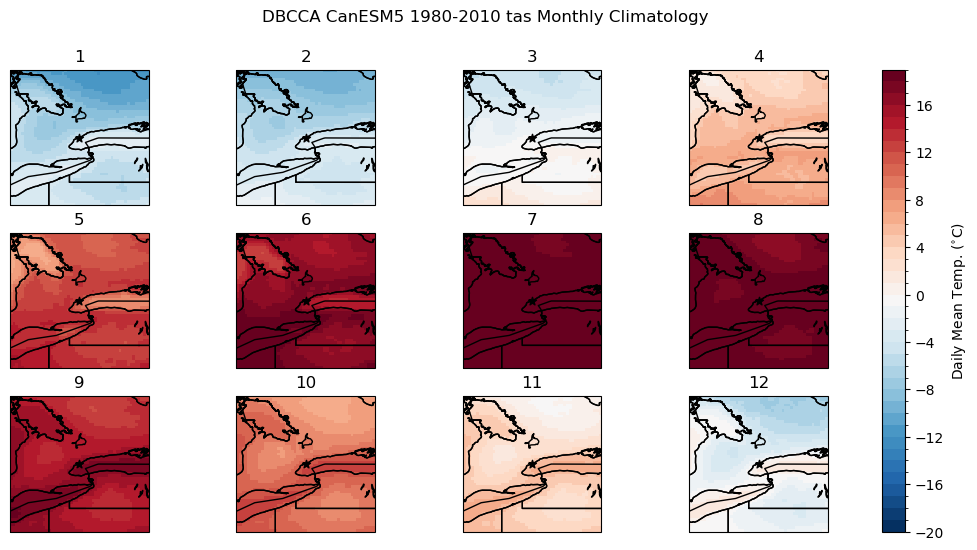

In [21]:
# de-chunk along the time dimension, required by xclim bias correction routines
tas_hist_raw_canesm = tas_hist_raw_canesm.chunk({'time': -1})
tas_ssp3_raw_canesm = tas_ssp3_raw_canesm.chunk({'time': -1})
tas_obs = tas_obs.chunk({'time': -1})

# file names for intermediate BCCA files - saving these will help the code run faster later on if all
# you want to do is the last QDM step

file_hist_canesm_bcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.canesm.toronto.historical.r10i1p1f1.1980-2010.BCCA.nc"
file_ssp3_canesm_bcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.canesm.toronto.ssp370.r10i1p1f1.2070-2100.BCCA.nc"

# file paths for DBCCA output - it's good to save this because the code can take a long time to run
file_hist_canesm_dbcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.canesm.toronto.historical.r10i1p1f1.1980-2010.DBCCA.nc"
file_ssp3_canesm_dbcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.canesm.toronto.ssp370.r10i1p1f1.2070-2100.DBCCA.nc"

# open pre-computed DBCCA data if it exists
if os.path.exists(file_hist_canesm_dbcca) and os.path.exists(file_ssp3_canesm_dbcca):
    ds_hist_dbcca = xr.open_dataset(file_hist_canesm_dbcca)
    tas_hist_dbcca = ds_hist_dbcca.tas
    ds_ssp3_dbcca = xr.open_dataset(file_ssp3_canesm_dbcca)
    tas_ssp3_dbcca = ds_ssp3_dbcca.tas 
else: # do the downscaling - this will only run if the input files don't already exist
    tas_hist_dbcca, tas_ssp3_dbcca = DBCCA(tas_hist_raw_canesm,
                                           tas_ssp3_raw_canesm,
                                           tas_obs,
                                           "tas", 
                                           units = "degC",
                                           fout_hist_bcca = file_hist_canesm_bcca,
                                           fout_future_bcca = file_ssp3_canesm_bcca,
                                           fout_hist_dbcca = file_hist_canesm_dbcca,
                                           fout_future_dbcca = file_ssp3_canesm_dbcca,
                                           write_output = True)
    
# calculate the downscaled model historical monthly climatology
tas_hist_dbcca_monthlyclim = tas_hist_dbcca.groupby('time.month').mean('time').compute()

# difference between downscaled and ERA5-Land
bias_clim_dbcca = tas_hist_dbcca_monthlyclim - tas_obs_monthlyclim

# plot model monthly clim
fig, axes_array = plt.subplots(nrows = 3, ncols = 4, subplot_kw = spkws, figsize = (14, 6))
axes = axes_array.ravel()
fig.suptitle("DBCCA CanESM5 1980-2010 tas Monthly Climatology")
for i in range(len(axes)):
    p = tas_hist_dbcca_monthlyclim.sel(month = i+1).plot.pcolormesh(ax = axes[i],
                                                                    levels = np.arange(-20, 20, 1),
                                                                    cmap = 'RdBu_r',
                                                                    add_colorbar = False)
    axes[i].set_title(i + 1)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    axes[i].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    axes[i].scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")
    
fig.colorbar(p, ax = axes.tolist(), label = r"Daily Mean Temp. ($^{\circ}$C)")
plt.show()

In [22]:
cdd_delta_raw_canesm = cdd_ssp3_raw_ltm - cdd_hist_raw_ltm

# add units to downscaled data
tas_hist_dbcca.attrs['units'] = 'degC'

# calculate CDDs using the historical DBCCA data
cdds_hist_dbcca = xci.cooling_degree_days(tas_hist_dbcca).compute()

# long-term mean
cdds_hist_dbcca_ltm = cdds_hist_dbcca.mean('time')

# bias of the downscaled data
cdds_hist_dbcca_ltm_bias = cdds_hist_dbcca_ltm - cdds_obs_ltm

# add units to downscaled future data
tas_ssp3_dbcca.attrs['units'] = 'degC'

# calculate CDDs using the SSP3-7.0 DBCCA data
cdds_ssp3_dbcca = xci.cooling_degree_days(tas_ssp3_dbcca).compute()

# long-term mean
cdds_ssp3_dbcca_ltm = cdds_ssp3_dbcca.mean('time')

# climate change delta
cdds_delta_dbcca_canesm = cdds_ssp3_dbcca_ltm - cdds_hist_dbcca_ltm


**Max Planck Institute Earth System Model (MPI)**

In [23]:
# downloading model data from google cloud

# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for our selected model, both historical and SSP3-7.0 scenarios
search_string = "table_id == 'day' & source_id == 'MPI-ESM1-2-LR' & variable_id == 'tas'" # continue on the next line
search_string += " & experiment_id == ['historical', 'ssp370']"
df_search = df_catalog.query(search_string)

# filter the search results further for the ensemble member we want to use
df_search_r10i1p1f1 = df_search.query("member_id == 'r10i1p1f1'")

# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# get the URLs for each dataset and turn into zarr store mappers
url_hist = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'historical'].zstore.values[0]
mapper_hist = gcs.get_mapper(url_hist)
url_ssp3 = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'ssp370'].zstore.values[0]
mapper_ssp3 = gcs.get_mapper(url_ssp3)

# download the datasets, subset, and convert units
# historical
ds_hist_raw = xr.open_zarr(mapper_hist, consolidated = True)
tas_hist_raw_earth3 = ds_hist_raw.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds360)) - 273.15 # also convert to C

# future
ds_ssp3_raw = xr.open_zarr(mapper_ssp3, consolidated = True)
tas_ssp3_raw_earth3 = ds_ssp3_raw.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds360)) - 273.15 

# select time periods
tas_hist_raw_earth3 = tas_hist_raw.sel(time = tas_hist_raw.time.dt.year.isin(years_hist))
tas_ssp3_raw_earth3 = tas_ssp3_raw.sel(time = tas_ssp3_raw.time.dt.year.isin(years_future))

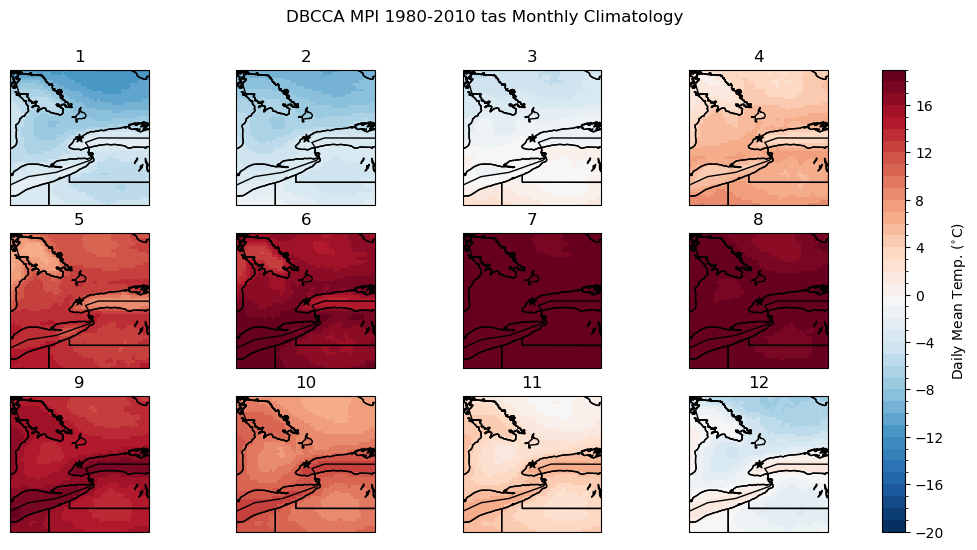

In [24]:
# de-chunk along the time dimension, required by xclim bias correction routines
tas_hist_raw_earth3  = tas_hist_raw.chunk({'time': -1})
tas_ssp3_raw_earth3  = tas_ssp3_raw.chunk({'time': -1})
tas_obs = tas_obs.chunk({'time': -1})

# file names for intermediate BCCA files - saving these will help the code run faster later on if all
# you want to do is the last QDM step

file_hist_earth3_bcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.MPI.toronto.historical.r10i1p1f1.1980-2010.BCCA.nc"
file_ssp3_earth3_bcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.MPI.toronto.ssp370.r10i1p1f1.2070-2100.BCCA.nc"

# file paths for DBCCA output - it's good to save this because the code can take a long time to run
file_hist_earth3_dbcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.MPI.toronto.historical.r10i1p1f1.1980-2010.DBCCA.nc"
file_ssp3_earth3_dbcca = "/home/cchanen/UTCDW/dbcca_data/tas.daily.MPI.toronto.ssp370.r10i1p1f1.2070-2100.DBCCA.nc"

# open pre-computed DBCCA data if it exists
if os.path.exists(file_hist_earth3_dbcca) and os.path.exists(file_ssp3_earth3_dbcca):
    ds_hist_dbcca = xr.open_dataset(file_hist_dbcca)
    tas_hist_dbcca = ds_hist_dbcca.tas
    ds_ssp3_dbcca = xr.open_dataset(file_ssp3_dbcca)
    tas_ssp3_dbcca = ds_ssp3_dbcca.tas 
else: # do the downscaling - this will only run if the input files don't already exist
    tas_hist_dbcca, tas_ssp3_dbcca = DBCCA(tas_hist_raw_earth3 ,
                                           tas_ssp3_raw_earth3 ,
                                           tas_obs,
                                           "tas", 
                                           units = "degC",
                                           fout_hist_bcca = file_hist_earth3_bcca,
                                           fout_future_bcca = file_ssp3_earth3_bcca,
                                           fout_hist_dbcca = file_hist_earth3_dbcca,
                                           fout_future_dbcca = file_ssp3_earth3_dbcca,
                                           write_output = True)
    
# calculate the downscaled model historical monthly climatology
tas_hist_dbcca_monthlyclim = tas_hist_dbcca.groupby('time.month').mean('time').compute()

# difference between downscaled and ERA5-Land
bias_clim_dbcca = tas_hist_dbcca_monthlyclim - tas_obs_monthlyclim

# plot model monthly clim
fig, axes_array = plt.subplots(nrows = 3, ncols = 4, subplot_kw = spkws, figsize = (14, 6))
axes = axes_array.ravel()
fig.suptitle("DBCCA MPI 1980-2010 tas Monthly Climatology")
for i in range(len(axes)):
    p = tas_hist_dbcca_monthlyclim.sel(month = i+1).plot.pcolormesh(ax = axes[i],
                                                                    levels = np.arange(-20, 20, 1),
                                                                    cmap = 'RdBu_r',
                                                                    add_colorbar = False)
    axes[i].set_title(i + 1)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    axes[i].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    axes[i].scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")
    
fig.colorbar(p, ax = axes.tolist(), label = r"Daily Mean Temp. ($^{\circ}$C)")
plt.show()

In [25]:
cdd_delta_raw_mp = cdd_ssp3_raw_ltm - cdd_hist_raw_ltm

# add units to downscaled data
tas_hist_dbcca.attrs['units'] = 'degC'

# calculate CDDs using the historical DBCCA data
cdds_hist_dbcca = xci.cooling_degree_days(tas_hist_dbcca).compute()

# long-term mean
cdds_hist_dbcca_ltm = cdds_hist_dbcca.mean('time')

# bias of the downscaled data
cdds_hist_dbcca_ltm_bias = cdds_hist_dbcca_ltm - cdds_obs_ltm

# add units to downscaled future data
tas_ssp3_dbcca.attrs['units'] = 'degC'

# calculate CDDs using the SSP3-7.0 DBCCA data
cdds_ssp3_dbcca = xci.cooling_degree_days(tas_ssp3_dbcca).compute()

# long-term mean
cdds_ssp3_dbcca_ltm = cdds_ssp3_dbcca.mean('time')

# climate change delta
cdds_delta_dbcca_mp = cdds_ssp3_dbcca_ltm - cdds_hist_dbcca_ltm


### 6.6.4.1 Comparing change in CDDs for all 3 models

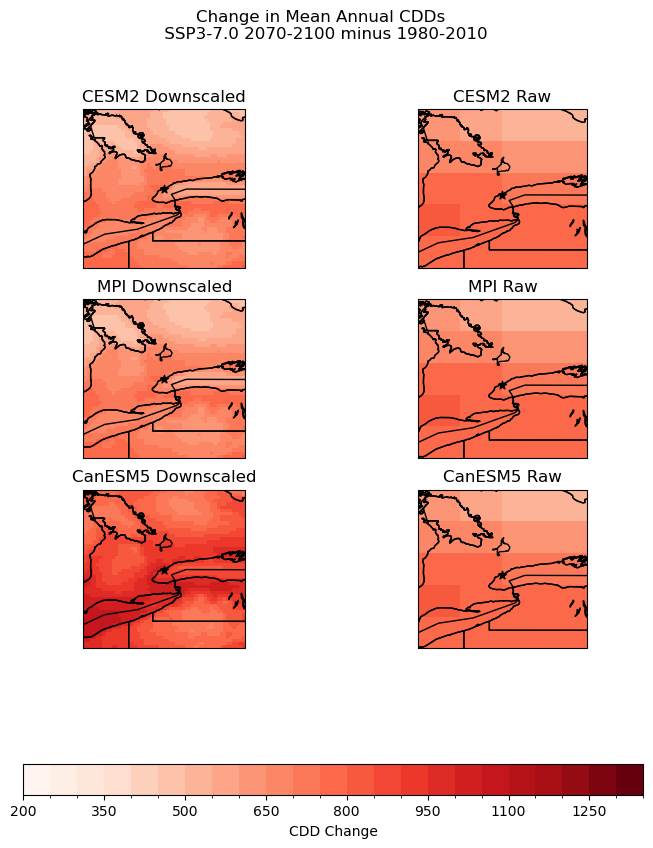

In [26]:
# plot maps of changes long-term mean CDDs for raw and downscaled CESM2
levels_cdd_delta = np.arange(200, 1400, 50)

fig, axes = plt.subplots(3,2, subplot_kw = spkws, figsize = (8, 10))

fig.suptitle("Change in Mean Annual CDDs \n SSP3-7.0 2070-2100 minus 1980-2010")

# CDDS Delta - CanESM5
cdds_delta_dbcca.plot.pcolormesh(ax = axes[0,0], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[0,0].set_title("CESM2 Downscaled")

# raw model
p = cdd_delta_raw.plot.pcolormesh(ax = axes[0,1], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[0,1].set_title("CESM2 Raw")

# CDDS Delta - MP
cdds_delta_dbcca_mp.plot.pcolormesh(ax = axes[1,0], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[1,0].set_title("MPI Downscaled")

# raw model
p = cdd_delta_raw_mp.plot.pcolormesh(ax = axes[1,1], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[1,1].set_title("MPI Raw")

# CDDS Delta - CESM2
cdds_delta_dbcca_canesm.plot.pcolormesh(ax = axes[2,0], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')

axes[2,0].set_title("CanESM5 Downscaled")

# raw model
p = cdd_delta_raw_canesm.plot.pcolormesh(ax = axes[2,1], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[2,1].set_title("CanESM5 Raw")

fig.colorbar(p, ax = axes.ravel().tolist(), orientation = 'horizontal', label = 'CDD Change')

for i in range(3):
    for j in range(2):
        axes[i,j].coastlines()
        axes[i,j].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
        axes[i,j].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
        axes[i,j].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
        axes[i,j].scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")


plt.show()

The plot above demonstrates how changing models can impact the results of downscaling. There is strong agreement between the MPI and CESM2 models, with almost identical high and low areas and scales of CDD change. In the CanESM5 model, changes in cooling degree days are more pronounced, however, the spatial distribution of highs and lows remains consistent, with high CDD change areas along the coast of Lake Ontario and lows in more rural Northern Ontario.

### 6.6.4.2 Multi-Model Mean

Multi-model means can be a useful way to summarize the results of many different models. Using the mean can help to reduce the impact of irregularities in different models and produce more reliable results. Means should be used carefully, as sometimes the differences between model results such as extreme values could be important to understanding the phenomenon you are looking at, or at understanding the behaviour of particular models.
In this case, with all three models equally weighted the the CanESM5 irregularities are less clear.

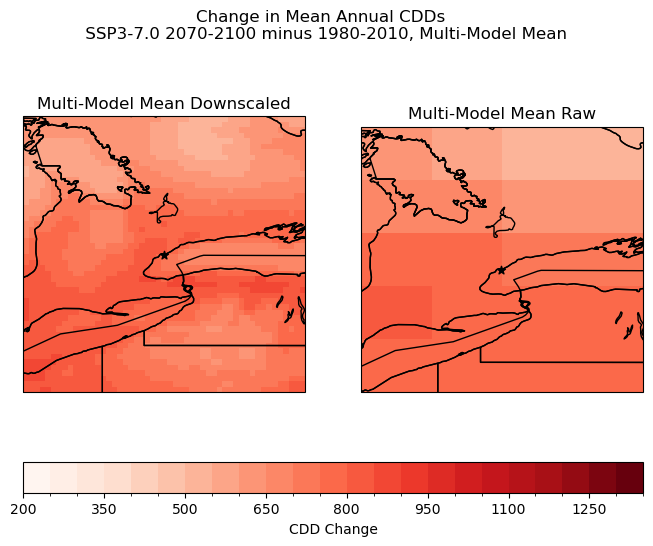

In [27]:
# plot maps of changes long-term mean CDDs for raw and downscaled multi-model
levels_cdd_delta = np.arange(200, 1400, 50)

fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8, 6))

fig.suptitle("Change in Mean Annual CDDs \n SSP3-7.0 2070-2100 minus 1980-2010, Multi-Model Mean")

# CDDS Delta - multi-model
average = (cdds_delta_dbcca + cdds_delta_dbcca_mp + cdds_delta_dbcca_canesm)/3

average.plot.pcolormesh(ax = axes[0], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[0].set_title("Multi-Model Mean Downscaled")

# raw model
p = cdd_delta_raw.plot.pcolormesh(ax = axes[1], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[1].set_title("Multi-Model Mean Raw")


fig.colorbar(p, ax = axes.ravel().tolist(), orientation = 'horizontal', label = 'CDD Change')


for j in range(2):
        axes[j].coastlines()
        axes[j].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
        axes[j].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
        axes[j].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
        axes[j].scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")


plt.show()

## 6.6.5 Exploring Indicator Choices

The results of both the QDM and DBCCA downscaling demonstrate that cooling degree days are a highly sensitive engineering variable. Small changes in average temperature over a season add up to significant increases in CDDs. 

Validating your choice in indicators is an important aspect of the engineering design process. Cooling Degree Days are a standard indicator that is easy to calculate, but may not be the best model for energy demand. Considering other indicators can help validate our choice in indicator and provide a more holistic understanding of future heat.

This section explores the impact of changing the engineering indicator on our results. Shifting from a climatic indicator (from the original model) to an engineering indicator is the last step of our analysis, so no further downscaling is required unless a new variable is required that was not previously downscaled.

The indicator chosen is a custom indicator which approximates of energy demand based on the historical relationship between temperature and energy use in Ontario. 

## 6.6.5.1 Custom Indicator: Historical Correlation

This section uses a custom model developped by Elise Emma Lagace that correlates daily maximum temperature to Ontario Electricity demand. The following figures from her Chapter 3 of her thesis <i> Assessing the Impact of Climate Change on Electricity Planning in Ontario, Canada </i> illustrates the strong correlation between energy use and electricity demand.

The full thesis document can be found here: <a href="https://tspace.library.utoronto.ca/handle/1807/109060">Lagace, 2021</a>

<img src="Toronto_Electricity_Images/lagace.png" alt="1">

Lagace performed a linear regression relating temperature and energy demand for each IESO region. The results of this regression are summarized in the figure and table below:

<img src="Toronto_Electricity_Images/lagace2.png" alt="2">
<img src="Toronto_Electricity_Images/lagace3.png" alt="2">

In order to simplify this stage of the analysis, the "Toronto" IESO zone values will be the focus since this is our primary area of interest, even though the plots in Section 3 cover a wider geographical area encompassing many Southern Ontario zones.

The change in hourly energy demand is presented as a percent change because the formulas provided are based off of total zonal energy demand, and without knowing the spatial distribution of energy use within the zone a downscaled plot with absolute values can not be calculated.

<h4> Defining Energy Use Function: <h4/>

In [28]:
def energy_use(data, dataout): 
    shape = np.shape(data)
    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                if data[i][j][k] <= 10:
                    dataout[i][j][k] = data[i][j][k]*(-46.61)
                elif dataout[i][j][k] <= 15:
                    dataout[i][j][k] = data[i][j][k]*(7.21)
                elif data[i][j][k] <= 20:
                    dataout[i][j][k] = data[i][j][k]*(106.74)
                else:
                    dataout[i][j][k] = data[i][j][k]*(242.87)
            return(dataout)

**Appling energy use function to DBCCA data:**

In [29]:
energy_ssp3_dbcca = tas_ssp3_dbcca
energy_hist_dbcca = tas_hist_dbcca

xr.apply_ufunc(
    energy_use,  # first the function
    tas_ssp3_dbcca.values,  # now arguments in the order expected by 'interp1_np'
    energy_ssp3_dbcca.values
)

xr.apply_ufunc(
    energy_use,  # first the function
    tas_hist_dbcca.values,  # now arguments in the order expected by 'interp1_np'
    energy_hist_dbcca.values
)


# long-term mean
energy_ssp3_dbcca_ltm = energy_ssp3_dbcca.mean('time')
energy_hist_dbcca_ltm = energy_hist_dbcca.mean('time')

# climate change delta
energy_delta_dbcca = 100*(energy_ssp3_dbcca_ltm - energy_hist_dbcca_ltm)/energy_hist_dbcca_ltm

#delta in summer
#group into months
energy_ssp3_dbcca_monthclim = energy_ssp3_dbcca.groupby('time.month').mean('time').compute()
energy_hist_dbcca_monthclim = energy_hist_dbcca.groupby('time.month').mean('time').compute()
monthly_delta = 100*(energy_ssp3_dbcca_monthclim - energy_hist_dbcca_monthclim)/energy_hist_dbcca_monthclim
august = monthly_delta.sel(month = 8)

**Appling energy use function to raw model data:**

In [30]:
energy_ssp3_raw = tas_ssp3_raw
energy_hist_raw = tas_hist_raw

xr.apply_ufunc(
    energy_use,  # first the function
    tas_ssp3_raw.values,  # now arguments in the order expected by 'interp1_np'
    energy_ssp3_raw.values
)

xr.apply_ufunc(
    energy_use,  # first the function
    tas_hist_raw.values,  # now arguments in the order expected by 'interp1_np'
    energy_hist_raw.values
)


# long-term mean
energy_ssp3_raw_ltm = energy_ssp3_raw.mean('time')
energy_hist_raw_ltm = energy_hist_raw.mean('time')

# climate change delta
energy_delta_raw = 100*(energy_ssp3_raw_ltm - energy_hist_raw_ltm)/energy_hist_raw_ltm

#delta in summer
#group into months
energy_ssp3_raw_monthclim = energy_ssp3_raw.groupby('time.month').mean('time').compute()
energy_hist_raw_monthclim = energy_hist_raw.groupby('time.month').mean('time').compute()
monthly_delta_raw = 100*(energy_ssp3_raw_monthclim - energy_hist_raw_monthclim)/energy_hist_raw_monthclim
august_raw = monthly_delta_raw.sel(month = 7)

**Plot Change in Hourly Energy Demand: Yearly Average**

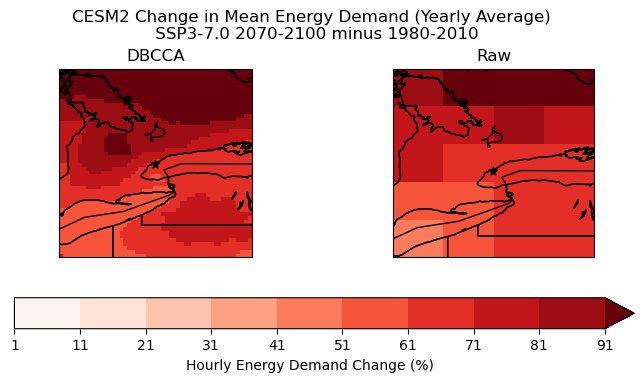

In [31]:
# plot maps of changes long-term mean CDDs for raw and downscaled CanESM5
levels_cdd_delta = np.arange(1, 100, 10)

fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8, 3.5))

fig.suptitle("CESM2 Change in Mean Energy Demand (Yearly Average) \n SSP3-7.0 2070-2100 minus 1980-2010", y = 1.05)

# downscaled model
energy_delta_dbcca.plot.pcolormesh(ax = axes[0], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[0].set_title("DBCCA")

# raw model
p = energy_delta_raw.plot.pcolormesh(ax = axes[1], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[1].set_title("Raw")

fig.colorbar(p, ax = axes.ravel().tolist(), orientation = 'horizontal', label = 'Hourly Energy Demand Change (%)')

for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    ax.scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")

plt.show()

**Plot change in hourly energy demand: August Average**

In [32]:
#Crop to Toronto Area
min_lon1 = -79.4-1
max_lon1 = -79.4+1

min_lon = -79.4-1+360
min_lat = 43.63-1
max_lon = -79.4+1+360
max_lat = 43.63+1

august_cropped = august.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon1,max_lon1))
august_raw_cropped = august_raw.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

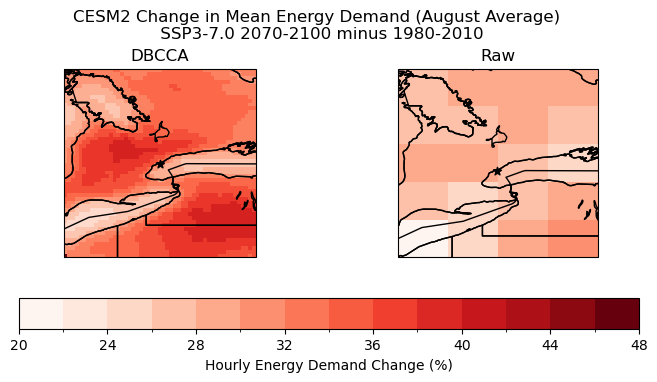

In [33]:
# plot maps of changes long-term mean CDDs for raw and downscaled CanESM5
levels_cdd_delta = np.arange(20, 50, 2)

fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8, 3.5))

fig.suptitle("CESM2 Change in Mean Energy Demand (August Average) \n SSP3-7.0 2070-2100 minus 1980-2010", y = 1.05)

# downscaled model
august.plot.pcolormesh(ax = axes[0], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[0].set_title("DBCCA")

# raw model
p = august_raw.plot.pcolormesh(ax = axes[1], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[1].set_title("Raw")

fig.colorbar(p, ax = axes.ravel().tolist(), orientation = 'horizontal', label = 'Hourly Energy Demand Change (%)')

for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    ax.scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")

plt.show()



The plot above demonstrates that using a custom indicator can provide new insights into the effects of future climate. For example, the distribution of high hourly energy demand change does not exactly match the distribution of increased CDD days from the previous section. There is a much clearer hotspot around Toronto, and the "low" region in Southwestern Ontario observed with CDD days is not present. 

The demand change is also notably lower around the Great Lakes when using the custom energy demand indicator. This makes sense because the indicator uses a piecewise function with significantly less sensitivity in the middle of the temperature range (around 15 degrees), and the high specific heat of water means that the temperature would change less rapidly in these areas. 

It should be noted that this indicator is still flawed in many ways. The current percent increase in hourly energy demand assumes that the relationship between temperature and energy is the same everywhere in the zone. A better engineering model is needed to produce more meaningful results. 

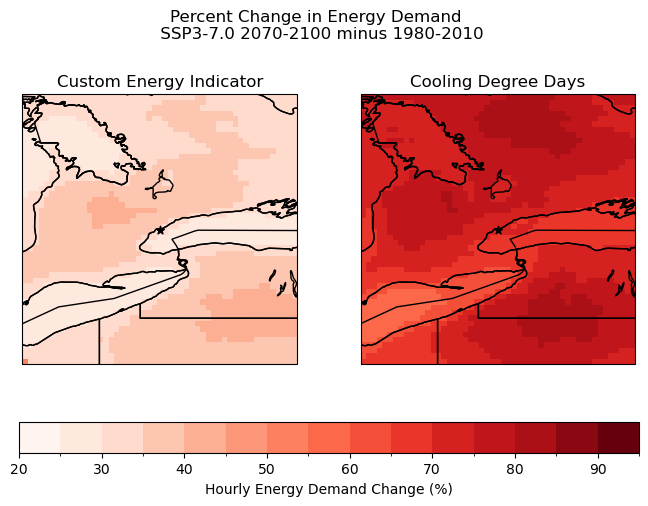

In [34]:
#first convert CDD delta values from first section into a percentage
cdd_delta_percent = 100*(cdds_delta_dbcca/cdds_ssp3_dbcca_ltm)

#now plot

levels_cdd_delta = np.arange(20,100,5)

fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8, 5))


fig.suptitle("Percent Change in Energy Demand \n SSP3-7.0 2070-2100 minus 1980-2010", y = 1.05)

# Using Custom Energy Indicator
august.plot.pcolormesh(ax = axes[0], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[0].set_title("Custom Energy Indicator")

# Using CDDs as Proxy for Energy
p = cdd_delta_percent.plot.pcolormesh(ax = axes[1], levels = levels_cdd_delta, 
                              add_colorbar = False,
                              cmap = 'Reds')
axes[1].set_title("Cooling Degree Days")

fig.colorbar(p, ax = axes.ravel().tolist(), orientation = 'horizontal', label = 'Hourly Energy Demand Change (%)')

for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    ax.scatter(lon_tor, lat_tor, label = "Toronto", color = 'k', marker = "*")

plt.show()
